In [ ]:
#! pip install -q kaggle

In [50]:
 from google.colab import files 

In [51]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"chandrapal22","key":"851287fc7e63ce61c3ac660cec351765"}'}

In [52]:
mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [53]:
! cp kaggle.json ~/.kaggle/

In [54]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [55]:
 ! kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  
roche-data-science-coalition/uncover                        UNCOVER COVID-19 Challenge                       179MB  2020-05-21 18:57:53          16825  
mrgeislinger/bart-ridership                                 BART Ridership                                   325MB  2020-07-09 22:28:07             86  
andrewmvd/data-analyst-jobs                                 Data Analyst Jobs                                  2MB  2020-07-14 08:37:57            744  
vishnuvarthanrao/windows-store                              Windows Store                                     93KB  2020-07-07 12:29:07            443  
moezabid/zillow-all-homes-data                              Zillow All Homes Data 

In [56]:
!kaggle datasets download -d alxmamaev/flowers-recognition -p /content

flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [57]:
!unzip \*.zip

Streaming output truncated to the last 5000 lines.
  inflating: flowers/flowers/rose/11102341464_508d558dfc_n.jpg  
  inflating: flowers/flowers/rose/11233672494_d8bf0a3dbf_n.jpg  
  inflating: flowers/flowers/rose/11694025703_9a906fedc1_n.jpg  
  inflating: flowers/flowers/rose/118974357_0faa23cce9_n.jpg  
  inflating: flowers/flowers/rose/11944957684_2cc806276e.jpg  
  inflating: flowers/flowers/rose/12165480946_c4a3fe182d_n.jpg  
  inflating: flowers/flowers/rose/12202373204_34fb07205b.jpg  
  inflating: flowers/flowers/rose/12238827553_cf427bfd51_n.jpg  
  inflating: flowers/flowers/rose/12240165555_98625b1e88_n.jpg  
  inflating: flowers/flowers/rose/12240303_80d87f77a3_n.jpg  
  inflating: flowers/flowers/rose/12240577184_b0de0e53ea_n.jpg  
  inflating: flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg  
  inflating: flowers/flowers/rose/12243069253_e512464095_n.jpg  
  inflating: flowers/flowers/rose/123128873_546b8b7355_n.jpg  
  inflating: flowers/flowers/rose/12323085443_8ac0

In [58]:
import keras
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import random

In [59]:
# path to your dataset
DATASET_PATH = './flowers'
flowers_cls = ['daisy', 'rose']

In [60]:
from google.colab import files
src = list(files.upload().values())[0]
open('resnet.py','wb').write(src)
import resnet



IndexError: ignored

In [ ]:
#!rm -rf resnet.py

In [13]:
import resnet

# specify image size and channels
img_channels = 3
img_rows = 100
img_cols = 100

# number of classes
nb_classes = 2

In [15]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    
    def __init__(self, mode='train', ablation=None, flowers_cls=['daisy', 'rose'], 
                 batch_size=32, dim=(100, 100), n_channels=3, shuffle=True):
        """
        Initialise the data generator
        """
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        
        # glob through directory of each class 
        for i, cls in enumerate(flowers_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
            
        self.n_channels = n_channels
        self.n_classes = len(flowers_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > 100 and img.shape[1] > 100:
                h, w, _ = img.shape
                img = img[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
            else:
                delete_rows.append(i)
                continue
            
            X[i,] = img
          
            # Store class
            y[i] = self.labels[ID]
        
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [16]:
# using resnet 18
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy', optimizer='SGD',
              metrics=['accuracy'])

# create data generator objects in train and val mode
# specify ablation=number of data points to train on
training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

# fit: this will fit the net on 'ablation' samples, only 1 epoch
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1,)

Epoch 1/1
6/6 [==============================] - 25s 4s/step - loss: 1.6119 - accuracy: 0.6198 - val_loss: 2.6163 - val_accuracy: 0.5000


In [17]:
# resnet 18
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

# generators
training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

# fit
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=20)

Epoch 1/20
6/6 [==============================] - 24s 4s/step - loss: 1.7103 - accuracy: 0.5417 - val_loss: 7.1898 - val_accuracy: 0.5156
Epoch 2/20
6/6 [==============================] - 20s 3s/step - loss: 1.5650 - accuracy: 0.7135 - val_loss: 5.9347 - val_accuracy: 0.4948
Epoch 3/20
6/6 [==============================] - 20s 3s/step - loss: 1.5383 - accuracy: 0.7448 - val_loss: 3.0772 - val_accuracy: 0.5000
Epoch 4/20
6/6 [==============================] - 20s 3s/step - loss: 1.4975 - accuracy: 0.8021 - val_loss: 3.2641 - val_accuracy: 0.5208
Epoch 5/20
6/6 [==============================] - 20s 3s/step - loss: 1.4608 - accuracy: 0.7917 - val_loss: 3.4043 - val_accuracy: 0.5625
Epoch 6/20
6/6 [==============================] - 24s 4s/step - loss: 1.4266 - accuracy: 0.8333 - val_loss: 2.4645 - val_accuracy: 0.5990
Epoch 7/20
6/6 [==============================] - 20s 3s/step - loss: 1.4107 - accuracy: 0.8750 - val_loss: 2.0849 - val_accuracy: 0.6354
Epoch 8/20
6/6 [==================

In [18]:
from keras import optimizers
from keras.callbacks import *

# range of learning rates to tune
hyper_parameters_for_lr = [0.1, 0.01, 0.001]

# callback to append loss
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

# instantiate a LossHistory() object to store histories
history = LossHistory()
plot_data = {}

# for each hyperparam: train the model and plot loss history
for lr in hyper_parameters_for_lr:
    print ('\n\n'+'=='*20 + '   Checking for LR={}  '.format(lr) + '=='*20 )
    sgd = optimizers.SGD(lr=lr, clipnorm=1.)
    
    # model and generators
    model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
    model.compile(loss='categorical_crossentropy',optimizer= sgd,
                  metrics=['accuracy'])
    training_generator = DataGenerator('train', ablation=100)
    validation_generator = DataGenerator('val', ablation=100)
    model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        epochs=3, callbacks=[history])
    
    # plot loss history
    plot_data[lr] = history.losses



========================================   Checking for LR=0.1  ========================================
Epoch 1/3
6/6 [==============================] - 25s 4s/step - loss: 1.6186 - accuracy: 0.6250 - val_loss: 4.8624 - val_accuracy: 0.4948
Epoch 2/3
6/6 [==============================] - 21s 3s/step - loss: 1.4381 - accuracy: 0.7656 - val_loss: 7.8599 - val_accuracy: 0.4844
Epoch 3/3
6/6 [==============================] - 20s 3s/step - loss: 1.4279 - accuracy: 0.8073 - val_loss: 5.9943 - val_accuracy: 0.4948


========================================   Checking for LR=0.01  ========================================
Epoch 1/3
6/6 [==============================] - 25s 4s/step - loss: 1.7043 - accuracy: 0.5000 - val_loss: 3.7275 - val_accuracy: 0.5104
Epoch 2/3
6/6 [==============================] - 20s 3s/step - loss: 1.6470 - accuracy: 0.5833 - val_loss: 1.9557 - val_accuracy: 0.4948
Epoch 3/3
6/6 [==============================] - 20s 3s/step - loss: 1.5876 - accuracy: 0.6979 - val

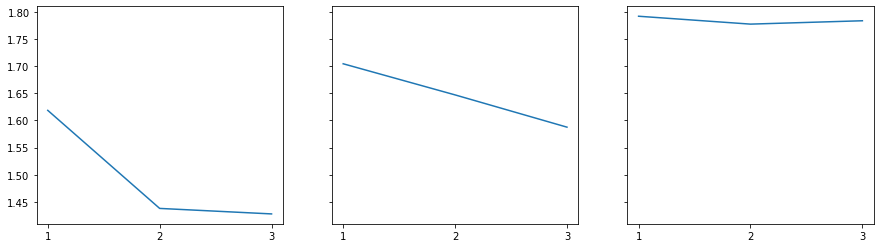

In [19]:
# plot loss history for each value of hyperparameter
f, axes = plt.subplots(1, 3, sharey=True)
f.set_figwidth(15)

plt.setp(axes, xticks=np.arange(0, len(plot_data[0.01]), 1)+1)

for i, lr in enumerate(plot_data.keys()):
    axes[i].plot(np.arange(len(plot_data[lr]))+1, plot_data[lr])

In [20]:
# learning rate decay
class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.001, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    # set lr on_train_begin
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    # change learning rate at the end of epoch
    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

# to store loss history
history = LossHistory()
plot_data = {}

# start with lr=0.1
decay = DecayLR(base_lr=0.1)

# model
sgd = optimizers.SGD()
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer= sgd,
              metrics=['accuracy'])
training_generator = DataGenerator('train', ablation=100)
validation_generator = DataGenerator('val', ablation=100)

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=3, callbacks=[history, decay])

plot_data[lr] = decay.lr_history

Epoch 1/3
6/6 [==============================] - 25s 4s/step - loss: 2.1201 - accuracy: 0.5833 - val_loss: 11.6338 - val_accuracy: 0.5208
Epoch 2/3
6/6 [==============================] - 20s 3s/step - loss: 2.1970 - accuracy: 0.5938 - val_loss: 6.6318 - val_accuracy: 0.5729
Epoch 3/3
6/6 [==============================] - 20s 3s/step - loss: 1.3440 - accuracy: 0.8385 - val_loss: 4.4973 - val_accuracy: 0.6406


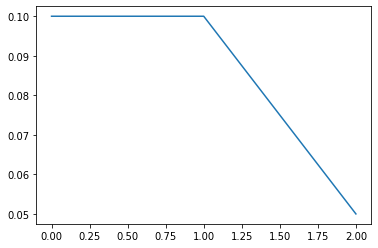

In [30]:
plt.plot(np.arange(len(decay.lr_history)), decay.lr_history)

In [41]:
# keras data generator
# help(ImageDataGenerator)

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [42]:
import numpy as np
import keras

# data generator with augmentation
class AugmentedDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, flowers_cls=['daisy', 'rose'], 
                 batch_size=32, dim=(100, 100), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(flowers_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:ablation]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(flowers_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = io.imread(ID)
            img = img/255
            if img.shape[0] > 100 and img.shape[1] > 100:
                h, w, _ = img.shape
                img = img[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]
            else:
                delete_rows.append(i)
                continue
            
            X[i,] = img
          
            # Store class
            y[i] = self.labels[ID]
        
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        # data augmentation
        if self.mode == 'train':
            aug_x = np.stack([datagen.random_transform(img) for img in X])
            X = np.concatenate([X, aug_x])
            y = np.concatenate([y, y])
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [45]:
from sklearn.metrics import roc_auc_score

class roc_callback(Callback):
    
    #def on_train_begin(self, logs={}):
    #    logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc


In [24]:
mkdir models

In [46]:
# model
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=32)
validation_generator = AugmentedDataGenerator('val', ablation=32)

# checkpoint 
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
auc_logger = roc_callback()

# fit 
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=3, callbacks=[auc_logger, history, decay, checkpoint])


Epoch 1/3
2/2 [==============================] - 17s 8s/step - loss: 1.6435 - accuracy: 0.5703 - val_loss: 14.7189 - val_accuracy: 0.5000

Val AUC for epoch0: 0.54443359375

Epoch 00001: val_auc improved from -inf to 0.54443, saving model to models/best_model.hdf5
Epoch 2/3
2/2 [==============================] - 12s 6s/step - loss: 2.6818 - accuracy: 0.4922 - val_loss: 5.4592 - val_accuracy: 0.6719

Val AUC for epoch1: 0.7802734375

Epoch 00002: val_auc improved from 0.54443 to 0.78027, saving model to models/best_model.hdf5
Epoch 3/3
2/2 [==============================] - 12s 6s/step - loss: 1.7409 - accuracy: 0.6172 - val_loss: 7.1021 - val_accuracy: 0.6406

Val AUC for epoch2: 0.751953125

Epoch 00003: val_auc did not improve from 0.78027


In [62]:
# globbing example
# help(glob)
flower_path = os.path.join(DATASET_PATH, flowers_cls[1], '*')
print(flower_path)

# glob through the directory (returns a list of all file paths)
flower_path = glob.glob(flower_path)
print(flower_path[3]) # access an individual file

./flowers/rose/*
./flowers/rose/7474124984_ca015e8c10_n.jpg


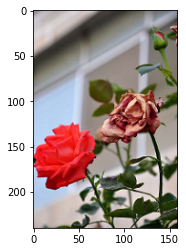

In [63]:
rand_index = random.randint(0, len(flower_path))
image = io.imread(flower_path[rand_index])
plt.imshow(image)

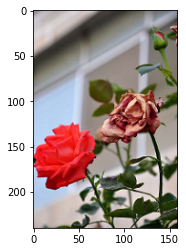

In [64]:
plt.imshow(image)

In [65]:
h, w, _ = image.shape
img = image[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, : ]

model.predict(img[np.newaxis,: ])

array([[1., 0.]], dtype=float32)

In [66]:
def _compute_grads(model, input_array):
    grads_fn = K.gradients(model.output, model.input)[0]
    compute_fn = K.function([model.input, K.learning_phase()], [grads_fn])
    return compute_fn([np.array([input_array]), 0])[0][0]

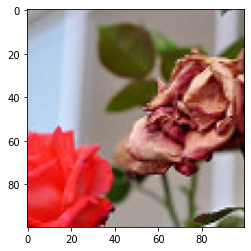

In [67]:
plt.imshow(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


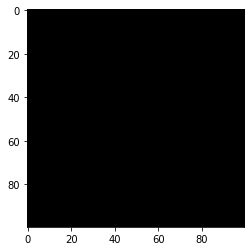

In [68]:
grad = _compute_grads(model, img)
grad_normed = (grad - np.min(grad))/(np.max(grad) - np.min(grad))
grad_normed *= 255
plt.imshow(grad_normed.astype('uint8'))